# **Trabajo Práctico 1 : Reservas de Hotel**
### *Checkpoint 3*
###Grupo 22: JARVIS
+ 107666	CELANO MINIG, NICOLÁS FRANCO
+ 108642	RANDO, JULIAN AGUSTIN
+ 106421	GOMEZ, ALEJO



#**KNeighborsClassifier**#

Realizamos los importes necesarios para trabajar.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Bajamos los dataframes que usaremos.

In [ ]:
hotels_train_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/df_hotel_v3.csv"
hotels_test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/hotels_test.csv"
df_original = pd.read_csv(hotels_train_url)
df_hotel_test = pd.read_csv(hotels_test_url)
df_hotel_test_con_is_canceled = df_hotel_test.copy()
df_hotel = df_original.copy()

Realizamos el tratamiento de datos que consideramos necesarios.

In [ ]:
df_hotel_test = df_hotel_test.drop('id', axis=1)
df_hotel_test = df_hotel_test.drop('arrival_date_week_number', axis=1)
df_hotel_test = df_hotel_test.drop('reservation_status_date', axis=1)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)
df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(int)
df_hotel['is_canceled'] = df_hotel['is_canceled'].astype(int)
df_hotel_test['company'] = df_hotel_test['company'].fillna('not company')
df_hotel_test['company'] = df_hotel_test['company'].astype(str)
df_hotel_test['agent'] = df_hotel_test['agent'].fillna('not agent')
df_hotel_test['agent'] = df_hotel_test['agent'].astype(str)

Con la siguiente funcion cambiaremos de algunas columnas por el valor de su media.



In [ ]:
def cambiar_columna_por_probabilidad_is_canceled(columna):
  global df_hotel_test, df_hotel
  probabilidades = df_hotel.groupby(columna)['is_canceled'].mean()
  nueva_columna = columna+'_prob_is_canceled'

  df_hotel[nueva_columna] = 0
  df_hotel[nueva_columna] = df_hotel[columna].map(probabilidades)

  df_hotel_test[nueva_columna] = 0
  df_hotel_test[nueva_columna] = df_hotel_test[columna].map(probabilidades)

  mediana = df_hotel_test[nueva_columna].median()
  df_hotel_test[nueva_columna].fillna(mediana, inplace=True)

  df_hotel_test = df_hotel_test.drop(columna, axis=1)
  df_hotel = df_hotel.drop(columna, axis=1)

Se la aplicaremos a todas las variables categóricas ya que consideramos que reemplazar sus valores por la media es mejor que realizar dummies de varias categorias porque aumenta la dimensionalidad del dataframe.

In [ ]:
variables_categoricas = ['country', 'agent', 'company', 'arrival_date_month', 'market_segment', 'distribution_channel', 'arrival_date_year', 
                         'hotel', 'meal', 'customer_type', 'assigned_room_type', 'deposit_type', 'reserved_room_type']

for variable in variables_categoricas:
  cambiar_columna_por_probabilidad_is_canceled(variable)

Dividimos el dataframe.

In [ ]:
X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']

Completamos con las columnas faltantes.

In [ ]:
columns_X = set(X.columns)
columns_test = set(df_hotel_test.columns)

missing_columns = list(columns_X - columns_test)
for column in missing_columns:
    df_hotel_test[column] = 0

df_hotel_test = df_hotel_test[X.columns]

Armamos un Knn utilizando Random search para la optimización de hiperparametros.


*   **n_neighbors**: especifica el número de vecinos más cercanos.
*   **weights**: determina el peso que se asignará a los vecinos más cercanos
*   **p**: determina la métrica de distancia utilizada para medir la cercanía entre puntos de datos.

Mejores hiperparámetros encontrados: {'weights': 'distance', 'p': 1, 'n_neighbors': 7}
F1_score en el conjunto de prueba: 0.7604091165337843
Accuracy en el conjunto de prueba: 0.7580907464628395
Precision en el conjunto de prueba: 0.7494840450865217
Recall en el conjunto de prueba: 0.7716574043805166


Text(50.722222222222214, 0.5, 'True')

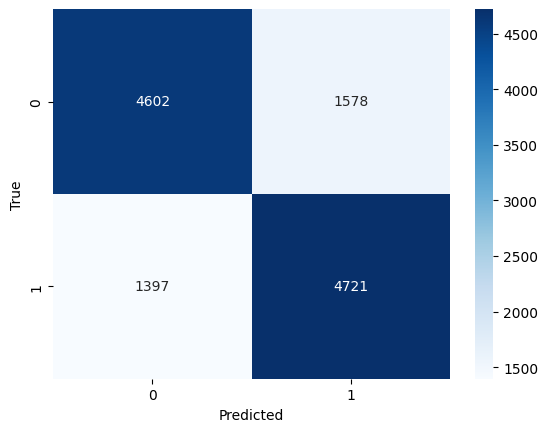

In [ ]:
param_dist = {'n_neighbors': [5,7,10,12],
              'weights': ['distance','uniform'],
              'p': [1,2],}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, n_iter=3, cv=5, scoring='f1', random_state=42)
random_search.fit(X, y)

best_params = random_search.best_params_

best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Mejores hiperparámetros encontrados:", best_params)
print("F1_score en el conjunto de prueba:", f1)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Precision en el conjunto de prueba:", precision)
print("Recall en el conjunto de prueba:", recall)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Los resultados muestran que el modelo ha obtenido un rendimiento general bueno, como se puede ver en el F1_score y Accuracy que están muy cercanos. La precisión y recall son medidas que muestran cómo se comporta el modelo en la clasificación de las instancias, y en este caso, la precisión es ligeramente más baja que el recall. Esto indica que el modelo puede estar enfocado en clasificar instancias como positivas, pero en general, ambos resultados son buenos.

Descargamos el modelo y realizamos la predicción correspondiente.

In [ ]:
joblib.dump(best_model, 'modelo_knn_final.pkl')
loaded_model = joblib.load('modelo_knn_final.pkl')
predicciones = loaded_model.predict(df_hotel_test)

In [ ]:
df_sub = pd.DataFrame({'id': df_hotel_test_con_is_canceled['id'], 'is_canceled': predicciones})
df_sub.to_csv('prediccion_knn_final.csv', index=False)